# Computer Assignment 2 Problem 2

## load data

In [262]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

In [263]:
# grab the name of files in the directory 'chrom'
# excluding the file with 'html' extension
# and store the names in a list

chrom_files = glob.glob('chrom/*')
chrom_files = [x for x in chrom_files if 'html' not in x]
print(f'# of files: {len(chrom_files)}')

# files ending with a are training data
# files ending with b are testing data

# list of training data
train_files = [x for x in chrom_files if 'a' in x]
print(f'# of training files: {len(train_files)}')

# list of testing data
test_files = [x for x in chrom_files if 'b' in x]
print(f'# of testing files:  {len(test_files)}')

# of files: 44
# of training files: 22
# of testing files:  22


In [264]:
# function that reads the contents of a file
# and returns a list of lines
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # for each line, take the string after '\t' and before '\n' as data
    # the second number is label
    data = [x.split('\t')[1].split('\n')[0] for x in lines]

    return data

def read_label(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # for each line, take the string after '\t' and before '\n' as data
    # the second number is label
    labels = [x.split('\t')[0] for x in lines]
    # split labels into a list of lists
    labels = [x.split(' ')[2] for x in labels]

    return labels


In [265]:
# read all the training data
train_data = [read_data(x) for x in train_files]
training_labels = [read_label(x) for x in train_files]
# flatten the list of lists
training_data = [item for sublist in train_data for item in sublist]
training_labels = [item for sublist in training_labels for item in sublist]
print(f'# of training data: {len(training_data)}')
print(f'# of training labels: {len(training_labels)}')

# read all the testing data
test_data = [read_data(x) for x in test_files]
# flatten the list of lists
test_data = [item for sublist in test_data for item in sublist]
test_labels = [read_label(x) for x in test_files]
test_labels = [item for sublist in test_labels for item in sublist]
print(f'# of testing data: {len(test_data)}')
print(f'# of testing labels: {len(test_labels)}')


# of training data: 2200
# of training labels: 2200
# of testing data: 2200
# of testing labels: 2200


In [266]:
# number of unique training data
unique_training_data = list(set(training_data))
print(f'# of unique training data: {len(unique_training_data)}')

# number of unique training labels
unique_training_labels = list(set(training_labels))
print(f'# of unique training labels: {len(unique_training_labels)}')

# number of unique testing data
unique_test_data = list(set(test_data))
print(f'# of unique testing data: {len(unique_test_data)}')

# number of unique testing labels
unique_test_labels = list(set(test_labels))
print(f'# of unique testing labels: {len(unique_test_labels)}')

# of unique training data: 2186
# of unique training labels: 170
# of unique testing data: 2189
# of unique testing labels: 166


In [267]:
# show the training data that appears more than once in the training data
# and the number of times it appears
# this is to check if there are any duplicates in the training data
# if there are duplicates, we need to remove them
# if there are no duplicates, we can move on to the next step
unique_training_data, counts = np.unique(training_data, return_counts=True)
print(f'# of unique training data that appears more than once: {len(unique_training_data[counts > 1])}')
# print(f'unique training data that appears more than once: {unique_training_data[counts > 1]}')
print(f'number of times each unique training data appears: {counts[counts > 1]}')

# show the testing data that appears more than once in the testing data
# and the number of times it appears
# this is to check if there are any duplicates in the testing data
# if there are duplicates, we need to remove them
# if there are no duplicates, we can move on to the next step
unique_test_data, counts = np.unique(test_data, return_counts=True)
print(f'# of unique testing data that appears more than once: {len(unique_test_data[counts > 1])}')
# print(f'unique testing data that appears more than once: {unique_test_data[counts > 1]}')
print(f'number of times each unique testing data appears: {counts[counts > 1]}')

'''# remove duplicates from training data
# remove duplicates from training labels
# remove duplicates from testing data
# remove duplicates from testing labels
training_data = list(set(training_data))
training_labels = list(set(training_labels))

test_data = list(set(test_data))
test_labels = list(set(test_labels))

# show the first training data and its label
print(f'first training data: {training_data[0]}')
print(f'first training label: {training_labels[0]}')'''



# of unique training data that appears more than once: 14
number of times each unique training data appears: [2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# of unique testing data that appears more than once: 11
number of times each unique testing data appears: [2 2 2 2 2 2 2 2 2 2 2]


"# remove duplicates from training data\n# remove duplicates from training labels\n# remove duplicates from testing data\n# remove duplicates from testing labels\ntraining_data = list(set(training_data))\ntraining_labels = list(set(training_labels))\n\ntest_data = list(set(test_data))\ntest_labels = list(set(test_labels))\n\n# show the first training data and its label\nprint(f'first training data: {training_data[0]}')\nprint(f'first training label: {training_labels[0]}')"

In [268]:
# show the training data that is duplicated in testing data
print(f'# of training data that is duplicated in testing data: {len(set(training_data).intersection(test_data))}')

'''# remove the training data that is duplicated in testing data
# remove the training labels that is duplicated in testing labels
training_data = list(set(training_data) - set(test_data))
training_labels = list(set(training_labels) - set(test_labels))
'''
print('I amm going to ignore the duplicates for now as it takes a lot of time to remove them while keeping the labels in order.')

# of training data that is duplicated in testing data: 18
I amm going to ignore the duplicates for now as it takes a lot of time to remove them while keeping the labels in order.


# String grammar hard C-means

## Label lookup

In [269]:
# class that returns the label of the given data
class label_lookup:
    def __init__(self, data, labels):
        # create a dictionary with data as key and label as value
        self.lookup = dict(zip(data, labels))

    def __call__(self, data):
        # return the label of the given data
        return self.lookup[data]
    
    def add_list(self, data, labels):
        # add a list of data and labels to the dictionary
        self.lookup.update(dict(zip(data, labels)))

    # return list of labels of the given list of data
    def get_labels(self, data):
        try:
            return [self.lookup[x] for x in data]
        except KeyError:
            return self.lookup[data]
    
    # return number of data in the dictionary
    def __len__(self):
        return len(self.lookup)
    
    # return all the keys of  a given value
    def get_key(self, value):
        return [k for k,v in self.lookup.items() if v == value]
    

# create an instance of label_lookup
lookup = label_lookup(training_data, training_labels)
print(f'# of data in the dictionary: {len(lookup)}')
lookup.add_list(test_data, test_labels)
print(f'# of data in the dictionary: {len(lookup)}')

print('test the label_lookup class')
print(f'data: {training_data[0]}')
print(f'label: {training_labels[0]}')
print(f'label from class: {lookup(training_data[0])}')

# of data in the dictionary: 2186
# of data in the dictionary: 4357
test the label_lookup class
data: A=====B=a==B===a==A==a=Aa===A===a===C==a=A=a==A==c=====Aa=A==c==A=a===a
label: 52
label from class: 52


## Class sgHCM

In [270]:
def levenshtein_distance(s1, s2):
        # Create a matrix to store the distances between substrings of s1 and s2
        distance_matrix = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

        # Initialize the first row and column of the matrix
        for i in range(len(s1) + 1):
            distance_matrix[i][0] = i
        for j in range(len(s2) + 1):
            distance_matrix[0][j] = j

        # Fill in the matrix using dynamic programming
        for i in range(1, len(s1) + 1):
            for j in range(1, len(s2) + 1):
                cost = 0 if s1[i - 1] == s2[j - 1] else 1
                distance_matrix[i][j] = min(
                    distance_matrix[i - 1][j] + 1,  # Deletion
                    distance_matrix[i][j - 1] + 1,  # Insertion
                    distance_matrix[i - 1][j - 1] + cost  # Substitution
                )

        # The final value in the bottom-right corner of the matrix is the Levenshtein distance
        return distance_matrix[len(s1)][len(s2)]

In [271]:
class sgHCM:
    # first, initial the class with k value
    # then, call the class with test sample and train data
    def __init__(self, k=3, max_iter=10, tol=1e-5):
        # number of clusters
        self.k = k
        # maximum iteration
        self.max_iter = max_iter
        # tolerance (epsilon)
        self.tol = tol
        # initialize the list of distances between old and new centroids very high
        self.Et = np.inf
        self.train_data = None
        self.centroids = None

    def __call__(self, test_sample):
        # compute the distance between test_sample and the centroids
        self.distances = self.compute_distance(test_sample, self.centroids)

        # find the index of the closest centroid
        closest_centroid = np.argmin(self.distances)

        # label of the closest centroid
        self.predicted_label = lookup(self.centroids[closest_centroid])

        return self.centroids[closest_centroid], self.predicted_label
        
    def fit(self, train_data):
        self.train_data = train_data
        # randomly select k centroids from train_data (or prototype vectors)
        self.centroids = np.random.choice(train_data, size=self.k, replace=False)

        # initialize the list of clusters
        self.clusters = [[] for _ in range(self.k)]

        # initialize the list of old centroids
        self.old_centroids = None

        # initialize the list of new centroids
        self.new_centroids = None

        # initialize the list of distances between test sample and each train data
        self.distances = None

        # initialize the list of predicted labels
        self.predicted_label = None

        self.u_ik = None
        self.n_it = None

        for t in range(self.max_iter):
            print(f'\nIteration {t + 1}')
            # assign each train data to the closest centroid
            self.clusters, self.u_ik = self.assign_clusters(self.train_data)

            # n_it is the number of train samples in the i-th cluster
            self.n_it = np.sum(self.u_ik, axis=0)

            # update the centroids
            self.old_centroids = self.centroids
            self.new_centroids = self.update_centroids(self.train_data)
            
            _ = self.centroids_uniqueness(self.new_centroids)
            # print(f'New centroids: {self.new_centroids}')

            # compute the difference between old and new centroids
            self.Et = self.compute_terminal_measure(self.old_centroids, self.new_centroids)

            # if the difference is less than the tolerance, stop the iteration
            if self.Et < self.tol:
                break

            # otherwise, update the centroids and continue
            self.centroids = self.new_centroids

        print(f'Final centroids: {self.centroids}')
        # return the list of clusters
        return self.clusters

    def assign_clusters(self, train_data):
        # compute the distance between the train data and each centroid
        # initialize the list of clusters
        clusters = [[] for _ in range(self.k)]

        # for each train data
        for i, train_sample in enumerate(train_data):
            # compute the distance between test_sample and the centroid
            self.distances = self.compute_distance(train_sample, self.centroids)

            # find the index of the closest centroid
            closest_centroid = np.argmin(self.distances)

            # assign the train sample to the closest centroid
            clusters[closest_centroid].append(i)

        # create the u_ik matrix, which is a matrix of 0s and 1s
        # u_ik[i][j] = 1 if the i-th train sample belongs to the j-th cluster
        # u_ik[i][j] = 0 otherwise
        u_ik = np.zeros((len(train_data), self.k))
        for i, cluster in enumerate(clusters):
            for j in cluster:
                u_ik[j][i] = 1

        self.n_it = np.sum(u_ik, axis=0)

        return clusters, u_ik
    
    def update_centroids(self, train_data):
        # compute the distance between each sample and other samples in the same cluster
        # the sample with the minimum sum of the distances to other samples in the same cluster is the new centroid for that cluster  

        # initialize the list of new centroids
        new_centroids = []

        # for each cluster
        for i in range(len(self.clusters)):
            # c_ij is a list of the sum of the distances to other samples in the same cluster
            c_ij = []

            for j in range(len(self.clusters[i])):
                # compute the distance between the sample and other samples in the same cluster excluding itself
                # list of samples excluding the sample itself
                samples = [x for x in self.clusters[i] if x != j]

                # take train_data at the index of samples
                train = np.array(train_data.copy())
                other_samples = train[samples]

                distances = self.compute_distance(train_data[j], other_samples)
                
                c_ij.append(np.sum(distances/self.n_it[i], axis=0))

            # find the index of the sample with the minimum sum 
            # of the distances to other samples in the same cluster
            try:
                alpha_q = np.argmin(c_ij)
            # except there is an error, which is the case when c_ij is empty, redraw the centroids
            except:
                print(f'Found empty cluster')
                self.centroids = np.random.choice(self.train_data, size=self.k, replace=False)
                return self.centroids

            # add the new centroid to the list
            new_centroids.append(train_data[alpha_q])

        return new_centroids
    
    def centroids_uniqueness(self, centroids):
        # check if the new centroids are unique
        # return True if the new centroids are unique
        # return False if the new centroids are not unique
        # print(f'Checking centroids uniqueness...')
        for i in range(len(centroids)):
            for j in range(len(centroids)):
                if i != j:
                    if centroids[i] == centroids[j]:
                        print(f'Found centroids not unique')
                        # redraw the centroids
                        self.centroids = np.random.choice(self.train_data, size=self.k, replace=False)
                        return False
        return True
    
    def levenshtein_distance(self, s1, s2):
        # Create a matrix to store the distances between substrings of s1 and s2
        distance_matrix = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

        # Initialize the first row and column of the matrix
        for i in range(len(s1) + 1):
            distance_matrix[i][0] = i
        for j in range(len(s2) + 1):
            distance_matrix[0][j] = j

        # Fill in the matrix using dynamic programming
        for i in range(1, len(s1) + 1):
            for j in range(1, len(s2) + 1):
                cost = 0 if s1[i - 1] == s2[j - 1] else 1
                distance_matrix[i][j] = min(
                    distance_matrix[i - 1][j] + 1,  # Deletion
                    distance_matrix[i][j - 1] + 1,  # Insertion
                    distance_matrix[i - 1][j - 1] + cost  # Substitution
                )

        # The final value in the bottom-right corner of the matrix is the Levenshtein distance
        return distance_matrix[len(s1)][len(s2)]

    def compute_distance(self, test_sample, train_data):
        # compute the distance between test_sample and each train data
        # return a list of distances
        distances = []
        for train_sample in train_data:
            distance = self.levenshtein_distance(test_sample, train_sample)
            distances.append(distance)
        return distances
    
    def compute_terminal_measure(self, old_V, new_V):
        # compute the levenstein distance between old and new centroids
        # return the sum of the levenstein distances
        Et = []
        for i in range(len(old_V)):
            Et.append(self.levenshtein_distance(old_V[i], new_V[i]))
    
        Et = np.array(Et)
        Et = np.sum(Et)
        print(f'Terminal measure: Et = {Et}')

        # return the tolerance
        return Et
    

In [272]:
# perform 10-fold cross validation on sgHCM classifier
def cross_validation(train_data, train_labels, test_data, k_num = 2, fold=10):
    # shuffle the number of samples in the training data 
    # and rearrange the labels accordingly

    # combine the training data and labels
    train_data = np.array(train_data)
    train_data = np.c_[train_data, train_labels]

    # shuffle the training data
    np.random.shuffle(train_data)

    # split the training data and labels
    train_labels = train_data[:, -1]
    train_data = train_data[:, :-1]    
    # convert train_data to 1 dimensional array
    train_data = train_data.ravel()

    fold_size = len(train_data) // fold

    accuracy_list = []
    num_of_unique_labels = []
    distances_list = []

    for i in range(fold):
        ############################ sgHCM classifier ##########################
        print(f"\nFold {i+1}")
        
        # take one fold as training data
        data_train_fold = train_data[i * fold_size: (i + 1) * fold_size]
        data_test_fold = test_data[i * fold_size: (i + 1) * fold_size]

        # show number of unique labels in the training data
        print(f'\nNumber of unique labels in the training data: {len(np.unique(train_labels))}')
        num_of_unique_labels.append(len(np.unique(train_labels)))
        
        classifier = sgHCM(k=k_num)
        classifier.fit(data_train_fold)

        # print('\nPredicting the test dataset...')
        print(f'Predictions: (test sample, test label, distance, predicted centroid label, predicted centroid)')
        predictions = []
        accuracy = 0
        distances_fold = []
        
        for j, test_sample in enumerate(data_test_fold):
            predicted_centroid, predicted_label = classifier(test_sample)
            predictions.append([test_sample, predicted_label, predicted_centroid])
            distances_fold.append(levenshtein_distance(test_sample, predicted_centroid))
            if j < 5:
                print(f'{test_sample}, {lookup(test_sample)}, {levenshtein_distance(test_sample, predicted_centroid)}, {predicted_label}, {predicted_centroid}')      
            if predicted_label == lookup(test_sample):
                accuracy += 1

        accuracy = accuracy / len(data_test_fold)
        print(f'Accuracy: {accuracy}')
        accuracy_list.append(accuracy)
        distances_list.append(np.mean(distances_fold))
     
        print('\n+++++++++++++++++++++++++++++++++++++++++++++++++++++')

    print(f'\nAverage accuracy: {np.mean(accuracy_list)}')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    return np.mean(accuracy_list), np.mean(num_of_unique_labels), np.mean(distances_list)

In [3]:
print([i for i in range(2, 30, 3)])

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29]


In [273]:
results = []
# k_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
k_list = [2, 4, 6, 8]

for k in k_list:
    print(f'\n\nk = {k}')
    accuracy, num_of_unique_labels, distances = cross_validation(training_data, 
                                training_labels, test_data, k_num = k)
    results.append([k, accuracy, num_of_unique_labels, distances])
    # cross_validation(training_data, training_labels, test_data, k_num = k)
print('\n\nDone')



k = 2

Fold 1

Number of unique labels in the training data: 170

Iteration 1


Terminal measure: Et = 28

Iteration 2
Terminal measure: Et = 14

Iteration 3
Terminal measure: Et = 0
Final centroids: ['A=Aa=====B====a=====A=b===========E====e=====A==a===a', 'A=B=====a==D==d======A==b==a']
Predictions: (test sample, test label, distance, predicted centroid label, predicted centroid)
A=B==a=A=a===B=a=A=aA=a=Aa======B====a==B===d====A==b====a, 52, 19, 66, A=Aa=====B====a=====A=b===========E====e=====A==a===a
A==B==a=A=a==A==a=A=a==A=a=====C===c====D==e===A=a==A=a=a, 6, 17, 66, A=Aa=====B====a=====A=b===========E====e=====A==a===a
A=A=a=B==a==B=a=A=a=A==a=A=a==B====b===C===d=====A==b===a, 40, 14, 66, A=Aa=====B====a=====A=b===========E====e=====A==a===a
A=Aa==B==b===A====B====a=A=a==B=====c====D===e=====A==a=a, 33, 14, 66, A=Aa=====B====a=====A=b===========E====e=====A==a===a
A==B=====a==A===a====B==a==B===aA===a===B===d==A=aA==b==a, 136, 19, 66, A=Aa=====B====a=====A=b===========E====e=====A==a===a
Accuracy: 0.004545454545454545

+++++++++++++++++++++++++++++++++++++

## Results

In [277]:
print('\nResults:')
print(f'(k, accuracy, number of unique labels, average distance)')
for result in results:
    print(result)


Results:
(k, accuracy, number of unique labels, average distance)
[2, 0.008181818181818182, 170.0, 17.215454545454545]
[4, 0.00909090909090909, 170.0, 15.586363636363638]
[6, 0.007727272727272727, 170.0, 15.001363636363635]
[8, 0.008636363636363636, 170.0, 14.850454545454548]


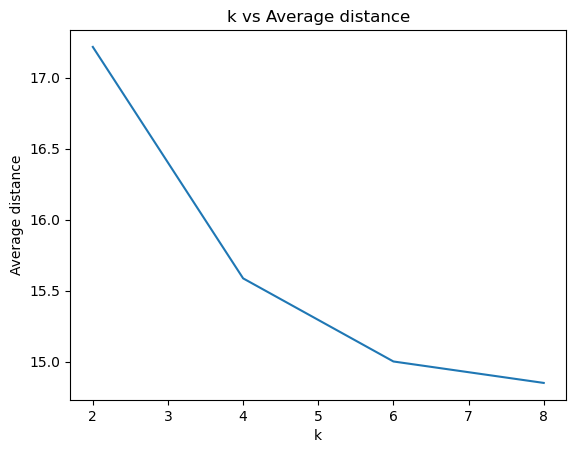

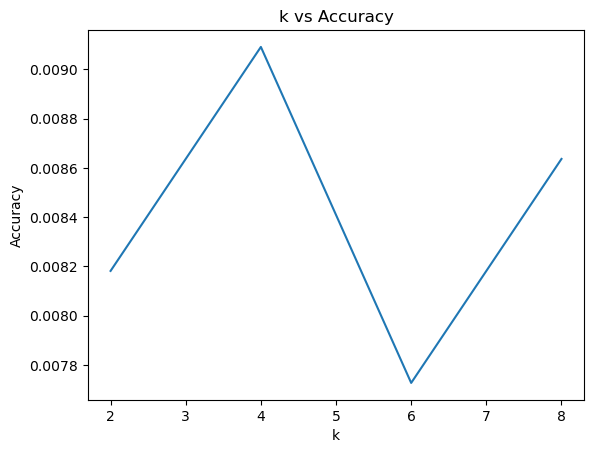

In [280]:
# plot k vs distance
k = [x[0] for x in results]
distance = [x[3] for x in results]
plt.plot(k, distance)
plt.xlabel('k')
plt.ylabel('Average distance')
plt.title('k vs Average distance')
plt.savefig('k vs Average distance.png')
plt.show()

# plot k vs accuracy
k = [x[0] for x in results]
accuracy = [x[1] for x in results]
plt.plot(k, accuracy)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.savefig('k vs Accuracy.png')
plt.show()
